# Age Prediction with a Convolutional Neural Network

Predicting the age of people who's age's range from 1-103, this Convolution Neural Network (CNN) uses blah blah blah layers etc




In [1]:

#  ! do not commit without checking markdown boxes first

## Imports

In [2]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import pad
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from PIL import ImageFile, Image

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline


## Create Dataset

In [3]:
def split_data(data: str):
    file = [file_name for file_name in os.listdir(data) if 
              file_name.endswith('.jpg')]
    label = [int(label.split('_')[0]) for label in file]
    dataset = zip(label, file)
    dataset = list(dataset)
    random.shuffle(dataset)
    split_80 = int(len(dataset)*0.8)
    split_10 = int((len(dataset)-split_80)/2)
    train = dataset[: split_80]
    val = dataset[split_80 : split_80 + split_10]
    test = dataset[split_80 + split_10 : (split_80 + (split_10*2))]
    return train, val, test

file_path = 'Data/Faces Grouped'
raw_train, raw_val, raw_test = split_data(file_path)

## Overload PyTorch Dataset


In [4]:
class ModelDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        path = os.path.join('Data/Faces Grouped/', self.data[index][1])
        image = Image.open(path).convert("RGB")
        label = self.data[index][0]
        if self.transform:
            image = self.transform(image)
        return label, image

## Define Transforms and Create Datasets

***************************************************
		    Image: 6137
		      Age: 22
***************************************************


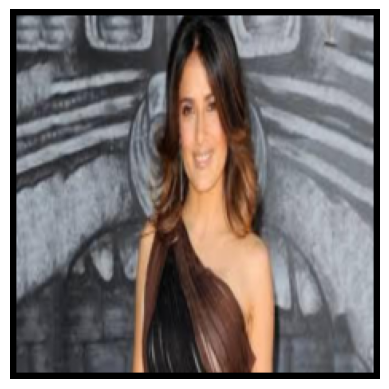

***************************************************
		    Image: 582
		      Age: 25
***************************************************


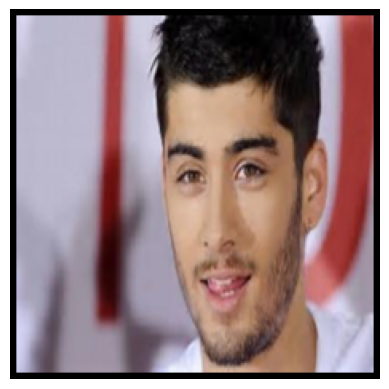

***************************************************
		    Image: 1601
		      Age: 34
***************************************************


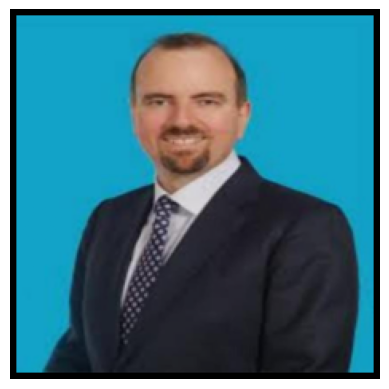

In [5]:
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Pad(padding=4, fill=(0,0,0), padding_mode='constant'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
    
train_data = ModelDataset(raw_train, img_transforms)
val_data = ModelDataset(raw_val, img_transforms)
test_data = ModelDataset(raw_test, img_transforms)

def show_image(data: Dataset):
    def denormalize(image):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean

    
    rdm_idx = random.randint(0, len(data))
    label, image = data.__getitem__(rdm_idx)
    d_image = denormalize(image)
    print('*'*51)
    print(f'\t\t    Image: {rdm_idx}')
    print(f'\t\t      Age: {label}')
    print('*'*51)
    plt.imshow(d_image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

show_image(train_data)
show_image(val_data)
show_image(test_data)


In [6]:
def plot_metrics(t_metric, v_metric, metric, num_epochs):
    """
    Displays accuracy and validation metrics plotted on line graphs.

    Args:
        t_metric (list): Accuracy/loss values during training.
        v_metric (list): Accuracy/loss values during validation.
        metric (str): Type of metric being plotted
        num_epochs (int): Number of epochs the model was trained.
    """
    plt.plot(t_metric, c='blue', label=f'Training')
    plt.plot(v_metric, c='red', label=f'Validation')
    plt.ylabel(f'{metric.title()}')
    plt.xlabel('Epoch')
    plt.title(f'{metric.title()} over {num_epochs} epochs')
    plt.legend()
    plt.show()

def train(dataloader, 
          model, 
          optimizer, 
          scheduler, 
          criterion,
          device, 
          epoch, 
          verbose=True):
    """
    Used to train a neural network.
    Sets the model to training mode and initialises variables to keep 
    track of metrics during training.
    Iterates through label/text pairs from each dataset making label
    predictions. 
    Calculates loss and backpropagates parameter updates
    through the network to ideally reduce loss over epochs.

    Args:
        dataloader (DataLoader): DataLoader containing training
            data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.sgd): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epoch (int): The current epoch.
        verbose (Boolean): Display metrics (default=True).

    Returns:
        epoch_loss, epoch_accuracy, epoch_count 
            (float, float, int): loss, accuracy and number of 
            predictions made in one epoch.
    """
    model.train()
    # Accuracy and loss of each prediction
    accuracy, loss = 0, 0
    # Accuracy and loss accumulated over epoch
    total_accuracy, total_loss = 0, 0
    # Number of predictions
    num_predictions = 0
    # Displays training metrics every quarter of epoch
    intervals = (len(dataloader) / 4).__round__()
    for idx, (label, image) in enumerate(dataloader):
        image = image.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.float32)
        # Make prediction
        prediction = model(image)
        # Calculate loss
        loss = criterion(prediction, label.float())
        batch_loss = loss.item()
        # Update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Store metrics
        accuracy += ((prediction > 0.5) == label).sum().item()
        total_loss += batch_loss
        num_predictions += label.size(0)
        total_accuracy += accuracy

        if verbose and idx % intervals == 0 and idx > 0:
            epoch_metrics = (
                f'| Epoch {epoch + 1} |' 
                f'{idx:5} / {len(dataloader):5} batches |' 
                f'{(accuracy/num_predictions)*100:.10f}% accurate |'
                )
            print(epoch_metrics)
            accuracy = 0
            num_predictions = 0
    scheduler.step()
    return total_loss, total_accuracy, num_predictions

def evaluate(dataloader, model, criterion, device):
    """
    Used to evaluate model training.
    Works similarly to the training method, allowing the model
    to make predictions on labelled data, however no parameters are
    updated.

    Args:
        dataloader (DataLoader): DataLoader containing either validation
            or testing data.
        model (nn.Module): The LSTM model being trained.
        criterion (torch.nn.modules.loss): Loss function.

    Returns:
        batch_loss, batch_accuracy, batch_count 
            (float, float, int): loss, accuracy and number of 
            predictions made over the validation set.
    """
    model.eval()
    total_accuracy = 0
    total_count = 0
    total_loss = 0
    with torch.no_grad():
        for idx, (label, image) in enumerate(dataloader):
            image = image.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.float32)
            prediction = model(image)
            loss = criterion(prediction, label.float())
            total_accuracy += ((prediction > 0.5) == label).sum().item()
            total_count += label.size(0)
            total_loss += loss.item()
    return total_loss, total_accuracy, total_count

def model_env(training, 
              validation, 
              testing, 
              model, 
              optimizer,
              scheduler, 
              criterion,
              device, 
              epochs, 
              verbose=True):
    """
    Wraps the training and evaluation functions in one method.
    At the end of each epoch, the model asseses the validation set.
    Once all epochs are complete performance is assesed on the test set.

    Args:
        training (DataLoader): DataLoader with training data.
        validation (DataLoader): DataLoader with validation data.
        testing (DataLoader): DataLoader with testing data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.sgd): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epochs (int): Number of epochs the model is trained for.
        verbose (Boolean): Display metrics (default=True).

    Returns:
        train_accuracy, train_loss, val_accuracy, val_loss 
            (list, list, list, list): Metrics saved during training and
            evaluation.
    """
    # Containers for training and evaluation metrics
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    # Time saved for calculating final processing time
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        print('-' * 59)
        print(f'|\t\t           Epoch {epoch + 1}           \t\t  |')
        print('-' * 59)
        # Process training data
        loss, acc, count = train(training, 
                                 model, 
                                 optimizer,
                                 scheduler, 
                                 criterion,
                                 device, 
                                 epoch, 
                                 verbose)  
        # Store training metrics
        train_loss.append(loss)
        train_accuracy.append(acc)
        # Evaluate validation data
        loss, acc, count = evaluate(validation, 
                                    model, 
                                    criterion, 
                                    device)
        # Store evaluation metrics
        val_loss.append(loss)
        val_accuracy.append(acc)
        val_ratio = (acc/count)*100
        print('-' * 59)
        epoch_metrics = (
            f'|  End of epoch {epoch + 1} |'
            f'Time: {time.time() - epoch_start:.2f}s |'
            f'Acc: {val_ratio:.14f}%  |'
        )
        print(epoch_metrics)
        print('-' * 59)
        print()
    # Assess model performance on test data
    loss, acc, count = evaluate(testing, model, criterion, device)
    test_ratio = (acc/count)*100
    total_time = (time.time() - start_time).__round__()/60
    print('*' + '-' * 57 + '*')
    test_metrics = (
        f'*\t\t\tTesting Epoch\t\t\t  *\n'
        f'*' + '-' * 57 + '*\n'
        f'* \t\t      Time: {total_time:.2f} minutes\t\t  *\n'
        f'*\t\t    Acc: {test_ratio:.14f}%     \t  *'
    )
    print(test_metrics)
    print('*' + '-' * 57 + '*')
    return train_accuracy, train_loss, val_accuracy, val_loss

In [31]:
class AgePrediction(nn.Module):
    def __init__(self):
        super(AgePrediction, self).__init__()
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 24, 3),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(24)
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(24, 48, 3),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.adptv_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Sequential(
            nn.Linear(48, 124),
            nn.BatchNorm1d(124),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(124, 62),
            nn.BatchNorm1d(62),
            nn.Dropout(0.2),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(62, 1)
        )

    def forward(self, image):
        x = self.c1(image)
        x = self.c2(x)
        x = self.adptv_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.squeeze(-1).squeeze(-1)
        return x

In [32]:
def set_device():
    """
    Device used to process tensors.
    """
    if torch.backends.mps.is_available():
        if torch.backends.mps.is_built():
            return torch.device("mps")
    else:
        return torch.device("cpu")
    
device = set_device()
print(device)
model_ = AgePrediction().to(device, dtype=torch.float32)
model = torch.compile(model_, backend='inductor')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.8)

params = sum(p.numel() for p in model.parameters())
print(f"CNN has {params} parameters.")

mps
CNN has 25493 parameters.


In [ ]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

epochs = 5
t_acc, t_loss, v_acc, v_loss = model_env(
    train_loader,
    val_loader,
    test_loader,
    model_,
    optimizer,
    scheduler,
    criterion,
    device,
    epochs,
    verbose=True
)